In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
aladdinpersson_flickr8kimagescaptions_path = kagglehub.dataset_download('aladdinpersson/flickr8kimagescaptions')

print('Data source import complete.')


100%|██████████| 1.04G/1.04G [00:07<00:00, 158MB/s]

Extracting files...


Data source import complete.


In [ ]:
image_path = "/root/.cache/kagglehub/datasets/aladdinpersson/flickr8kimagescaptions/versions/1/flickr8k/images"
caption_path = "/root/.cache/kagglehub/datasets/aladdinpersson/flickr8kimagescaptions/versions/1/flickr8k/captions.txt"

In [ ]:
import os  # when loading file paths
import pandas as pd  # for lookup in annotation file
from PIL import Image  # Load img
import matplotlib.pyplot as plt
import statistics
import spacy  # for tokenizer
import torch
import torch.nn as nn
from torch.nn.utils.rnn import pad_sequence  # pad batch
from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import torch.optim as optim
from torch.utils.tensorboard import SummaryWriter
import torchvision.models as models
import torchvision.transforms as transforms

import warnings
warnings.simplefilter('ignore')

## Building the Vocabulary

In [ ]:
spacy_eng = spacy.load("en_core_web_sm")

In [ ]:
class Vocabulary:
    def __init__(self, freq_threshold):
        self.itos = {0: "<PAD>", 1: "<SOS>", 2: "<EOS>", 3: "<UNK>"}
        self.stoi = {"<PAD>":0, "<SOS>": 1, "<EOS>":2, "<UNK>":3 }
        self.freq_threshold = freq_threshold
    def __len__(self):
        return len(self.itos)

    @staticmethod
    def tokenizer_eng(text):
        return [tok.text.lower() for tok in spacy_eng.tokenizer(text)]

    def build_vocabulary(self, sentences):
        idx=4
        frequency = {}
        for sentence in sentences:
            for word in self.tokenizer_eng(sentence):
                if word not in frequency:
                    frequency[word] = 1
                else:
                    frequency[word]+=1

                if ((word not in self.stoi) and (frequency[word] > self.freq_threshold-1)):
                    self.itos[idx] = word
                    self.stoi[word] = idx
                    idx+=1
        return frequency

    def numericalize(self, sentence):
        tokenized_text = self.tokenizer_eng(sentence)
        return [self.stoi[word] if word in self.stoi
                else self.stoi["<UNK>"] for word in tokenized_text]

In [ ]:
sen = [
    "The dog is running",
    "A boat with a dog sinking in the ocean",
    "dog playing with frisbe"
]

voc = Vocabulary(1)
freq = voc.build_vocabulary(sen)
print(voc.itos)

{0: '<PAD>', 1: '<SOS>', 2: '<EOS>', 3: '<UNK>', 4: 'the', 5: 'dog', 6: 'is', 7: 'running', 8: 'a', 9: 'boat', 10: 'with', 11: 'sinking', 12: 'in', 13: 'ocean', 14: 'playing', 15: 'frisbe'}


In [ ]:
print(voc.stoi["dog"])
print(voc.itos[voc.stoi["dog"]])

5
dog


## Dataset

In [ ]:
df = pd.read_csv(caption_path)
images = df['image']
captions = df["caption"]
df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
class FlickrDataset(Dataset):
    def __init__(self, root_dir=image_path,
                 caption_path=caption_path,
                 freq_threshold=5, transform=None):
        self.freq_threshold = freq_threshold
        self.transform = transform
        self.root_dir = root_dir
        self.df = pd.read_csv(caption_path)
        self.captions = self.df['caption']
        self.images = self.df['image']

        self.vocab = Vocabulary(freq_threshold)

        print(len(self.captions.tolist()))

        self.vocab.build_vocabulary(self.captions.tolist())

    def __len__(self):
      return len(self.df)

    def __getitem__(self,index) :
      caption = self.captions[index]
      image = self.images[index]

      img = Image.open(os.path.join(self.root_dir, image)).convert("RGB")

      if (self.transform):
        img = self.transform(img)

      numericalized_caption = [self.vocab.stoi["<SOS>"]]
      numericalized_caption += self.vocab.numericalize(caption)
      numericalized_caption.append(self.vocab.stoi["<EOS>"])

      return img, torch.tensor(numericalized_caption)

In [ ]:
class MyCollate:
    def __init__(self, pad_value):
        self.pad_value = pad_value

    def __call__(self,batch):
        imgs = [item[0].unsqueeze(0) for item in batch]
        img = torch.cat(imgs, dim=0)
        targets = [item[1] for item in batch]
        targets = pad_sequence(targets, batch_first=False, padding_value=self.pad_value)

        return img, targets

In [ ]:
transform = transforms.Compose(
    [
        transforms.Resize((356,356)),
        transforms.RandomCrop((299,299)),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [ ]:
def get_loader(
    root_dir = image_path,
    captions_path = caption_path,
    transform = transform, batch_size = 32, num_workers = 8,
    shuffle = True, pin_memory = True):
  dataset = FlickrDataset(root_dir=root_dir, caption_path = captions_path,
                          transform = transform)
  pad_value = dataset.vocab.stoi["<PAD>"]
  loader = DataLoader(dataset=dataset, batch_size=32, num_workers=num_workers,
                      shuffle = shuffle, pin_memory=pin_memory, collate_fn = MyCollate(pad_value))
  return loader, dataset


In [ ]:
loader, dataset = get_loader()

10000


## Model Definition

In [ ]:
class EncoderCNN(nn.Module):
  def __init__(self, embed_size, train_cnn = False):
    super().__init__()
    self.train_cnn = train_cnn
    self.inception = models.inception_v3(pretrained = True,aux_logits= False )
    self.inception.fc = nn.Linear(in_features= self.inception.fc.in_features,
                               out_features=embed_size)
    self.dropout = nn.Dropout(0.5)
    ##freeze the layer
    for name, param in self.inception.named_parameters():
      if "fc.weight" in name or "fc.bias" in name:
          param.requires_grad = True
      else:
          param.requires_grad = train_cnn

    self.relu = nn.ReLU()

  def forward(self, images):
    features = self.inception(images)
    output = self.dropout(self.relu(features))
    return output



In [ ]:
class DecoderRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers):
    super().__init__()
    self.embed = nn.Embedding(vocab_size, embed_size) ##lookup table for vocab indices
    self.lstm = nn.LSTM(input_size = embed_size,
                        hidden_size = hidden_size, num_layers = num_layers)
    self.linear = nn.Linear(in_features= hidden_size, out_features = vocab_size)
    self.dropout = nn.Dropout(0.5)

  def forward(self, features, captions):
    embeddings = self.dropout(self.embed(captions))
    ### try removing below line and see how the model's performance changes
    embeddings = torch.cat((features.unsqueeze(0), embeddings), dim=0)
    hiddens,_ = self.lstm(embeddings)
    outputs = self.linear(hiddens)
    return outputs

In [ ]:
class CNNtoRNN(nn.Module):
  def __init__(self, embed_size, hidden_size, vocab_size, num_layers) :
    super().__init__()
    self.encoder = EncoderCNN(embed_size)
    self.decoder = DecoderRNN(embed_size, hidden_size, vocab_size, num_layers)
  def forward(self, images, captions) :
    features = self.encoder(images)
    outputs = self.decoder(features, captions)
    return outputs
  def caption_image(self, image, vocabulary, max_length = 50): ## for model inference
    result_caption= []
    with torch.no_grad():
      x = self.encoder(image).unsqueeze(0)
      states = None
      for _ in range(max_length):
        hiddens, states = self.decoder.lstm(x, states)

        output = self.decoder.linear(hiddens.squeeze(0))

        predicted = output.argmax(1)
        result_caption.append(predicted.item())

        x = self.decoder.embed(predicted).unsqueeze(0)

        if vocabulary.itos[predicted.item()]=="<EOS>":
          break
    return [vocabulary.itos[idx] for idx in result_caption]


In [ ]:
def save_checkpoint(state, filename = "my_checkpoint.pth.tar"):
  print("=> Saving Checkpoint")
  torch.save(state, filename)

def load_checkpoint(checkpoint, model, optimizer):
  print("=> Loading Checkpoint")
  model.load_state_dict(checkpoint["state_dict"])
  optimizer.load_state_dict(checkpoint["optimizer"])
  step = checkpoint["step"]
  return step

In [ ]:
torch.backends.cudnn.benchmark = True
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
load_model = False
save_model = True
train_CNN = False

## Model Training

In [ ]:
step = 0
embed_size = 256
hidden_size = 256
num_layers = 1
num_epochs = 100
learning_rate = 3e-4
vocab_size =len(dataset.vocab)

In [ ]:
model = CNNtoRNN(embed_size = embed_size, hidden_size= hidden_size,
                 num_layers = num_layers, vocab_size=vocab_size).to(device)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 174MB/s]


In [ ]:
loss_fn = nn.CrossEntropyLoss(ignore_index = dataset.vocab.stoi["<PAD>"])
optimizer = optim.Adam(model.parameters(), lr= learning_rate)

In [ ]:
if load_model:
  step = load_checkpoint(torch.load("my_checkpoint.pth.tar"),
                         model, optimizer)


In [ ]:
model.train()

for epoch in range(1):
  for idx, (imgs, captions) in enumerate(loader) :
    imgs = imgs.to(device)
    captions = captions.to(device)

    score = model(imgs, captions[:-1])

    optimizer.zero_grad()
    loss = loss_fn(score.reshape(-1, score.shape[2]),
                   captions.reshape(-1))

    step+=1

    loss.backward()
    optimizer.step()
  print(f"Loss for epoch {epoch}: {loss}")

  if save_model:
    checkpoint = {
        "state_dict": model.state_dict(),
        "optimizer" : optimizer.state_dict(),
        "step": step
    }
    save_checkpoint(checkpoint)

Loss for epoch 0: 4.4012556076049805
=> Saving Checkpoint


In [ ]:
def infer_pipeline(index):
  df = pd.read_csv(caption_path, sep=',')
  images = df['image'].tolist()
  captions = df['caption'].tolist()
  infer_image_path = images[index]
  image = Image.open(image_path +"/"+infer_image_path)
  plt.imshow(image)
  plt.axis("off")
  plt.show()
  print("Original Caption: ", captions[index])
  model.eval()
  test_img = transform(image.convert("RGB")).unsqueeze(0)
  print("Generated Caption : "+" ".join(model.caption_image(test_img.to(device), dataset.vocab)))


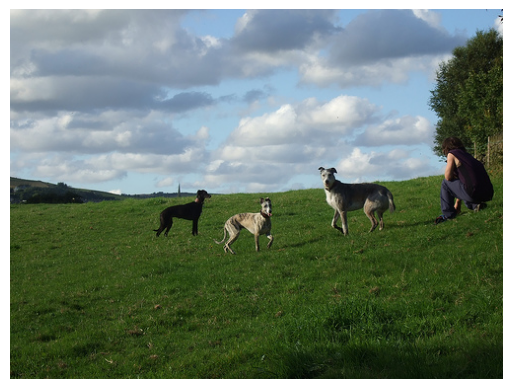

Original Caption:  A woman crouches near three dogs in a field .
Generated Caption : <SOS> a man in a a a a a . <EOS>


In [ ]:
infer_pipeline(140)